# Pre requisites

Install and import required packages

In [138]:
from google.colab import drive
drive.mount('/content/drive')
paths = '/content/drive/MyDrive/Pytorch_Projects/Project_1'

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [139]:
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torchsummary import summary # Visualize the model layers and number of parameters
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score
from tqdm import tqdm
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cpu


In [140]:
data_df = pd.read_csv(paths + '/data/riceClassification.csv')
data_df.head()

,id,Area,MajorAxisLength,MinorAxisLength,Eccentricity,ConvexArea,EquivDiameter,Extent,Perimeter,Roundness,AspectRation,Class
0,1,4537,92.229316,64.012769,0.719916,4677,76.004525,0.657536,273.085,0.764510,1.440796,1
1,2,2872,74.691881,51.400454,0.725553,3015,60.471018,0.713009,208.317,0.831658,1.453137,1
2,3,3048,76.293164,52.043491,0.731211,3132,62.296341,0.759153,210.012,0.868434,1.465950,1
3,4,3073,77.033628,51.928487,0.738639,3157,62.551300,0.783529,210.657,0.870203,1.483456,1
4,5,3693,85.124785,56.374021,0.749282,3802,68.571668,0.769375,230.332,0.874743,1.510000,1


In [141]:
data_df.dropna(inplace=True)
data_df.drop(['id'],axis=1, inplace=True)
print(data_df.shape)
print(data_df['Class'].unique())
print(data_df['Class'].value_counts())

(18185, 11)
[1 0]
Class
1    9985
0    8200
Name: count, dtype: int64


In [142]:
original_df = data_df.copy()
for column in data_df.columns:
  data_df[column] = data_df[column]/data_df[column].abs().max()

In [143]:
X=np.array(data_df.iloc[:,:-1])
y=np.array(data_df.iloc[:,-1])

In [144]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)
X_test, X_val, y_test, y_val = train_test_split(X_test, y_test,test_size=0.2)
print(X_train.shape)
print(X_test.shape)
print(X_val.shape)


(14548, 10)
(2909, 10)
(728, 10)


In [145]:
class dataset(Dataset):
  def __init__(self,X,y):
      self.X =torch.tensor(X,dtype=torch.float32).to(device)
      self.y =torch.tensor(y,dtype=torch.long).to(device)
  def __len__(self):
    return len(self.X)
  def __getitem__(self,index):
    return self.X[index] ,self.y[index]


In [146]:
training_data = dataset(X_train,y_train)
validation_data = dataset(X_val,y_val)
testing_data = dataset(X_test,y_test)

In [147]:
BATCH_SIZE = 32
EPOCHS = 15
HIDDEN_NEURONS = 10
LR = 1e-3

In [148]:
train_dataloader = DataLoader(training_data, batch_size=BATCH_SIZE, shuffle= True)
val_dataloader = DataLoader(validation_data, batch_size=BATCH_SIZE, shuffle= True)
testing_dataloader = DataLoader(testing_data, batch_size=BATCH_SIZE, shuffle= True)

In [149]:
print("Training set is: ", X_train.shape[0], " rows which is ", round(X_train.shape[0]/data_df.shape[0],4)*100, "%") # Print training shape
print("Validation set is: ",X_val.shape[0], " rows which is ", round(X_val.shape[0]/data_df.shape[0],4)*100, "%") # Print validation shape
print("Testing set is: ",X_test.shape[0], " rows which is ", round(X_test.shape[0]/data_df.shape[0],4)*100, "%") # Print testing shape

Training set is:  14548  rows which is  80.0 %
Validation set is:  728  rows which is  4.0 %
Testing set is:  2909  rows which is  16.0 %


In [150]:
class NeuralNetwork(nn.Module):
  def __init__(self):
    super(NeuralNetwork,self).__init__()
    self.input_layer = nn.Linear(X_train.shape[1],HIDDEN_NEURONS)
    self.linear = nn.Linear(HIDDEN_NEURONS,1)
    self.sigmid =nn.Sigmoid()

  def forward(self,x):
    x = self.input_layer(x)
    x = self.linear(x)
    x = self.sigmid(x)
    return x


In [151]:
model  = NeuralNetwork().to(device)
print(summary(model,(X.shape[1],)))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1                   [-1, 10]             110
            Linear-2                    [-1, 1]              11
           Sigmoid-3                    [-1, 1]               0
Total params: 121
Trainable params: 121
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.00
Params size (MB): 0.00
Estimated Total Size (MB): 0.00
----------------------------------------------------------------
None


In [152]:
criterion = nn.BCELoss()
optimizer = torch.optim.Adam(model.parameters(),lr=LR)

In [153]:
total_loss_train_plot = []
total_loss_val_plot = []
total_acc_train_plot = []
total_acc_val_plot = []

##Training
for epoch in range(EPOCHS):
  total_acc_train=0
  total_loss_train=0
  total_acc_val=0
  total_loss_val=0
  total_acc_val = 0
  for data in train_dataloader:
    inputs ,labels = data
    predictions = model(inputs).squeeze(1)
    batch_loss = criterion(predictions,labels.float())
    total_loss_train += batch_loss.item()
    acc = (predictions.round() == labels).sum().item()
    total_acc_train += acc
    batch_loss.backward()
    optimizer.step()
    optimizer.zero_grad()


##Validation
  with torch.no_grad():
    for data in val_dataloader:
      inputs ,labels = data
      predictions = model(inputs).squeeze(1)
      batch_loss = criterion(predictions,labels.float())
      total_loss_val += batch_loss.item()
      acc = (predictions.round() == labels).sum().item()
      total_acc_val += acc

  total_loss_train_plot.append(round(total_loss_train/1000,4))
  total_loss_val_plot.append(round(total_loss_val/1000,4))
  total_acc_train_plot.append(round(total_acc_train/(training_data.__len__())*100, 4))
  total_acc_val_plot.append(round(total_acc_val/(validation_data.__len__())*100, 4))

  print(f'''Epoch no. {epoch + 1} Train Loss: {total_loss_train/1000:.4f} Train Accuracy: {(total_acc_train/(training_data.__len__())*100):.4f} Validation Loss: {total_loss_val/1000:.4f} Validation Accuracy: {(total_acc_val/(validation_data.__len__())*100):.4f}''')
  print("="*50)



Epoch no. 1 Train Loss: 0.2759 Train Accuracy: 81.9082 Validation Loss: 0.0107 Validation Accuracy: 98.7637
Epoch no. 2 Train Loss: 0.1384 Train Accuracy: 97.9860 Validation Loss: 0.0042 Validation Accuracy: 98.6264
Epoch no. 3 Train Loss: 0.0613 Train Accuracy: 98.3503 Validation Loss: 0.0023 Validation Accuracy: 98.4890
Epoch no. 4 Train Loss: 0.0386 Train Accuracy: 98.4603 Validation Loss: 0.0016 Validation Accuracy: 98.3516
Epoch no. 5 Train Loss: 0.0298 Train Accuracy: 98.5015 Validation Loss: 0.0013 Validation Accuracy: 98.4890
Epoch no. 6 Train Loss: 0.0256 Train Accuracy: 98.5771 Validation Loss: 0.0011 Validation Accuracy: 98.7637
Epoch no. 7 Train Loss: 0.0231 Train Accuracy: 98.6046 Validation Loss: 0.0010 Validation Accuracy: 98.6264
Epoch no. 8 Train Loss: 0.0217 Train Accuracy: 98.5771 Validation Loss: 0.0010 Validation Accuracy: 98.4890
Epoch no. 9 Train Loss: 0.0208 Train Accuracy: 98.6390 Validation Loss: 0.0009 Validation Accuracy: 98.6264
Epoch no. 10 Train Loss: 0.0

##Testing
Now in this section, we will be testing our model, we will start the code by with torch.no_grad(): which means that we are telling PyTorch that we don't want to train the model we will be using it only for testing. Then we will declare initial loss and accuracy as zeros, we will start by looping through the testing dataloader like we did before during training. Inside the loop, we got our data and we moved it to our GPU (cuda) and then we ran our model on the data and we got the predictions. After that we get the loss and then we add it to our overall loss, we do the same for accuracy, and finally we print the accuracy.

In [154]:
with torch.no_grad():
  total_loss_test = 0
  total_acc_test=0
  for data in testing_dataloader:
    inputs,labels = data
    prediction = model(inputs).squeeze(1)
    batch_loss_test = criterion(prediction,labels.float())
    total_loss_test +=batch_loss_test.item()
    acc = (prediction.round() == labels).sum().item()
    total_acc_test += acc
print(f"Accuracy Score is: {round((total_acc_test/X_test.shape[0])*100, 2)}%")

Accuracy Score is: 98.69%


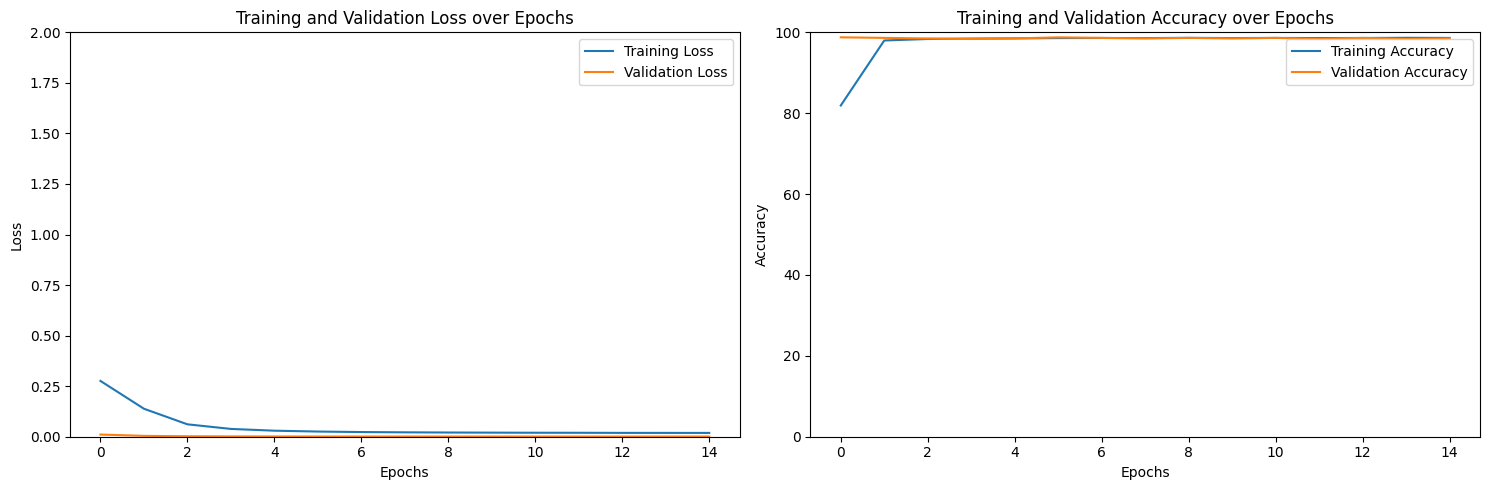

In [155]:
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(15, 5))

axs[0].plot(total_loss_train_plot, label='Training Loss')
axs[0].plot(total_loss_val_plot, label='Validation Loss')
axs[0].set_title('Training and Validation Loss over Epochs')
axs[0].set_xlabel('Epochs')
axs[0].set_ylabel('Loss')
axs[0].set_ylim([0, 2])
axs[0].legend()

axs[1].plot(total_acc_train_plot, label='Training Accuracy')
axs[1].plot(total_acc_val_plot, label='Validation Accuracy')
axs[1].set_title('Training and Validation Accuracy over Epochs')
axs[1].set_xlabel('Epochs')
axs[1].set_ylabel('Accuracy')
axs[1].set_ylim([0, 100])
axs[1].legend()

plt.tight_layout()

plt.show()

In [156]:
area = float(input("Area: "))/original_df['Area'].abs().max()
MajorAxisLength = float(input("Major Axis Length: "))/original_df['MajorAxisLength'].abs().max()
MinorAxisLength = float(input("Minor Axis Length: "))/original_df['MinorAxisLength'].abs().max()
Eccentricity = float(input("Eccentricity: "))/original_df['Eccentricity'].abs().max()
ConvexArea = float(input("Convex Area: "))/original_df['ConvexArea'].abs().max()
EquivDiameter = float(input("EquivDiameter: "))/original_df['EquivDiameter'].abs().max()
Extent = float(input("Extent: "))/original_df['Extent'].abs().max()
Perimeter = float(input("Perimeter: "))/original_df['Perimeter'].abs().max()
Roundness = float(input("Roundness: "))/original_df['Roundness'].abs().max()
AspectRation = float(input("AspectRation: "))/original_df['AspectRation'].abs().max()

my_inputs = [area, MajorAxisLength, MinorAxisLength, Eccentricity, ConvexArea, EquivDiameter, Extent, Perimeter, Roundness, AspectRation]

print("="*20)
model_inputs = torch.Tensor(my_inputs).to(device)
prediction = (model(model_inputs))
print(prediction)
print("Class is: ", round(prediction.item()))

Area:  6431.279
Major Axis Length: 145.21338
Minor Axis Length: 56.902
Eccentricity: 0.919981821
Convex Area: 6518.93759999
EquivDiameter: 90.483541
Extent: 0.8506668
Perimeter: 329.972
Roundness: 0.742255516
AspectRation: 2.551696
tensor([0.7573], grad_fn=<SigmoidBackward0>)
Class is:  1
